## In this project we use the machine learning methods to classify protein domains using their sequence of amino acids.  The objective is to predict the family accession of the given sequence of the protein domain.

# Install and import necessary packages and modules

In [1]:
#@title Import dependencies
import glob
from os import path
import pandas as pd
import numpy as np
from numpy import asarray
import seaborn as sns
import matplotlib.pyplot as plt
import gc

from scipy import stats

#sklearn used as the pre- and post-processing steps of the downstream task 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.manifold import TSNE #t-sne for data visualisation of the embedding vectors

#keras for the downstream task (classification of protein domains)
#import keras
#from keras import backend as K
#from keras import regularizers
#from keras.models import Model, Sequential # basic class for specifying and training a neural network
#from keras.layers import Input, Dense, Dropout, Activation

#Modules that will be used for pre-trained models
!pip3 install tensorflow transformers sentencepiece h5py

from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, AveragePooling3D, Layer, BatchNormalization, Add, Lambda, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from transformers import T5EncoderModel, T5Tokenizer
import torch
import h5py

import time

from tqdm.keras import TqdmCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 31.6 MB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
     |████████████████████████████████| 596 kB 54.2 MB/s 
     |████████████████████████████████| 6.6 MB 35.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Parsing the data

First we download and decompress the data then we read the files and create train, validation, and test dataframes.

In [2]:
#Download the data (you can find the data here: https://www.kaggle.com/datasets/googleai/pfam-seed-random-split)
!gdown --id '1A_Vi-QI9ex-TUVV2pPAkgn2qlwG5cw1Z' 
#Decompress the data
!unzip -q -n '/content/Pfamseedrandomsplit.zip'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1A_Vi-QI9ex-TUVV2pPAkgn2qlwG5cw1Z
To: /content/Pfamseedrandomsplit.zip
100% 517M/517M [00:04<00:00, 115MB/s]


In [3]:
# Query all the files in the train, valid, and test sets!
train_files = glob.glob(path.join('random_split', 'train', '*'))
valid_files = glob.glob(path.join('random_split', 'dev', '*'))
test_files = glob.glob(path.join('random_split', 'test', '*'))

In [4]:
# A function to combine the files of a set into one dataframe
def read_data(train_files):
    data = []
    for f in train_files:
        data.append(pd.read_csv(f, sep=',', index_col=None))
    return pd.concat(data)

In [5]:
# Use the function read_data to read files and combine them into a dataframe for each set!
train_df = read_data(train_files)
valid_df = read_data(valid_files)
test_df = read_data(test_files)

Now let's check the content of each sets! Visit [here](https://www.kaggle.com/datasets/googleai/pfam-seed-random-split) for the description of the fields and data structure.

In [6]:
train_df.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,Hexokinase_1,W1QBV3_OGAPD/6-206,PF00349.21,EVDKIVSEFAVTQETL.HKGVERFI.ELA....................,EVDKIVSEFAVTQETLHKGVERFIELATAGLNSDEDKYGLPMIPTF...
1,NADHdh,D3PT44_MEIRD/51-372,PF00146.21,IKAFLVI...FG.LLTAFA.YMTLIERRLLARIQIRQGPNR........,IKAFLVIFGLLTAFAYMTLIERRLLARIQIRQGPNRVGPTGLLQPL...
2,ThiC-associated,THIC_SHEDO/22-104,PF13667.6,QHPNSEKVFLS..GSR.PDLRVGMRQIHQTDTLHAKT..NGETLRE...,QHPNSEKVFLSGSRPDLRVGMRQIHQTDTLHAKTNGETLREQNPPI...
3,EXS,J5K896_BEAB2/18-387,PF03124.14,FPLPYRVGFIVTLAVWGWGLNL....H....GLQ...L.S.........,FPLPYRVGFIVTLAVWGWGLNLHGLQLSRIDVPSLIRYPGRTSPAA...
4,CobA_CobO_BtuR,Q486X4_COLP3/45-215,PF02572.15,ERGVLVVITGNGKGKSTSGFGTVLRAIGHG...................,ERGVLVVITGNGKGKSTSGFGTVLRAIGHGQKAGVVQFIKGTKWEC...


In [7]:
test_df.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,Ribosomal_L28,G2PE79_STRVO/4-62,PF00830.19,.HCQLTG.RQPGFGHH.....I....S.HS...............H...,HCQLTGRQPGFGHHISHSHRRTKRRFDPNIQHKRYWLPSEGRHIRL...
1,DUF2073,A3CWG8_METMJ/15-119,PF09846.9,LERLTAMEKIRLILDDVMEGNIVILEKGLAPDEQSKLIEITMREIA...,LERLTAMEKIRLILDDVMEGNIVILEKGLAPDEQSKLIEITMREIA...
2,UPF0052,B8HTP5_CYAP4/137-423,PF01933.18,IVAIGGGTGLSTLL..............RGLKEYS..............,IVAIGGGTGLSTLLRGLKEYSANITAIVTVADDGGSSGRLRREIGV...
3,SBD_N,Q12HD1_POLSJ/12-248,PF07005.11,LAYYGDDFTGSTDVMEAFSA.....AGV........PTVLF.LRP....,LAYYGDDFTGSTDVMEAFSAAGVPTVLFLRPPTADWLKRFPEVRCV...
4,LepA_C,D7G0L8_ECTSI/605-711,PF06421.12,INGEDAPPLSTVCHRDQAHQRGKVLTEKLKQLIPRQMFRVPIQACI...,INGEDAPPLSTVCHRDQAHQRGKVLTEKLKQLIPRQMFRVPIQACI...


In [8]:
valid_df.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,Ank,Y502_TREPA/243-275,PF00023.30,NGQTALV..L................A...............V......,NGQTALVLAVGRKDHVLIRLLMDHGANPYLEDK
1,LrgB,R5LI56_9SPIR/16-230,PF04172.16,TLIAYIIS....YAIYIK.T.K...LPILTPLVTSAILVGFSL......,TLIAYIISYAIYIKTKLPILTPLVTSAILVGFSLYFMNIPYSVYNE...
2,Lzipper-MIP1,W1P7E2_AMBTC/726-807,PF14389.6,ALHERRLALE.....QDVARLQEQLQKERDLRALLE.AGL.........,ALHERRLALEQDVARLQEQLQKERDLRALLEAGLNMPSEGYAISSS...
3,DUF2922,A0Q3K1_CLONN/3-69,PF11148.8,KLLVMNFITNK.G..KKMNIKVKDIKPD......IEEETVAEVMNA...,KLLVMNFITNKGKKMNIKVKDIKPDIEEETVAEVMNAIIDKNVFLS...
4,2OG-Fe_Oxy_2,A5VC55_SPHWW/45-237,PF10014.9,AGSWERLGDDRFMADGGR......YRRRRHAVF.......AVGR.....,AGSWERLGDDRFMADGGRYRRRRHAVFAVGRDVVRKPHQPHYQSRD...


# Data analysis

In this section we analyze the datasets to answer the following questions:

- What is the proportion of the train, validation, and test sets?
- How the sequence length is distributed for each family?
- How are the target classes (family_accession) distributed in train, validation, and test sets? 
- Are the target classes balanced in the training set? If not? how can we deal with the imbalanced dataset?

In [9]:
# First let's see the proportion of the train, validation, and test sets
n_samples = len(train_df) + len(valid_df) + len(test_df) 
print('The proportion of train set: %f' % (len(train_df) / n_samples))
print('The proportion of valid set: %f' % (len(valid_df) / n_samples))
print('The proportion of test set: %f' % (len(test_df) / n_samples))

The proportion of train set: 0.811556
The proportion of valid set: 0.094222
The proportion of test set: 0.094222


So the train set contains 80% of the data while validation and test set each has 10% of the data.

Since we will analyze sequences it is crucial to know that the distribution of sequence length is the same for train, validation and test set. This is particularly important because the we intend to extract contextual information from sequences and the length of samples should be similar between train, valid, and test sets. 

(0.0, 750.0)

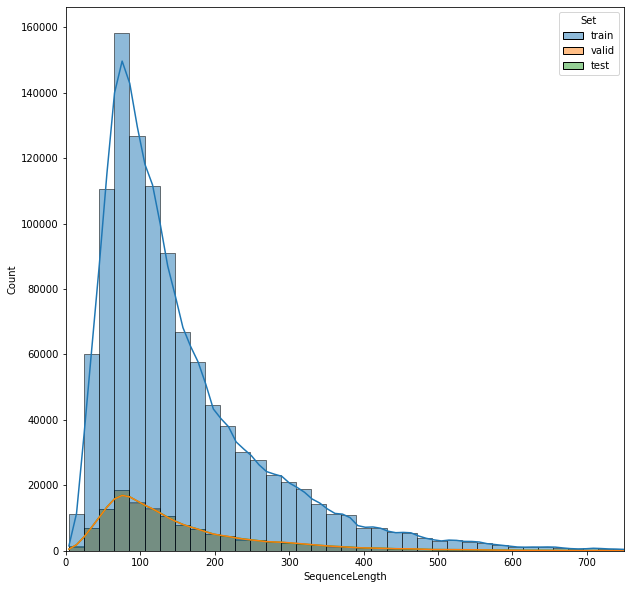

In [10]:
seqlen_train = list(zip(train_df.sequence.apply(len).to_list(), ['train']*len(train_df)))
seqlen_valid = list(zip(valid_df.sequence.apply(len).to_list(), ['valid']*len(valid_df)))
seqlen_test = list(zip(test_df.sequence.apply(len).to_list(), ['test']*len(test_df)))
seqlen_df = pd.DataFrame(data=seqlen_train+seqlen_valid+seqlen_test, columns=['SequenceLength','Set'])
plt.figure(figsize=(10,10))
sns.histplot(data=seqlen_df, x="SequenceLength", hue="Set", kde=True, bins=100)
plt.xlim(0,750)

A closer look:

(0.0, 200.0)

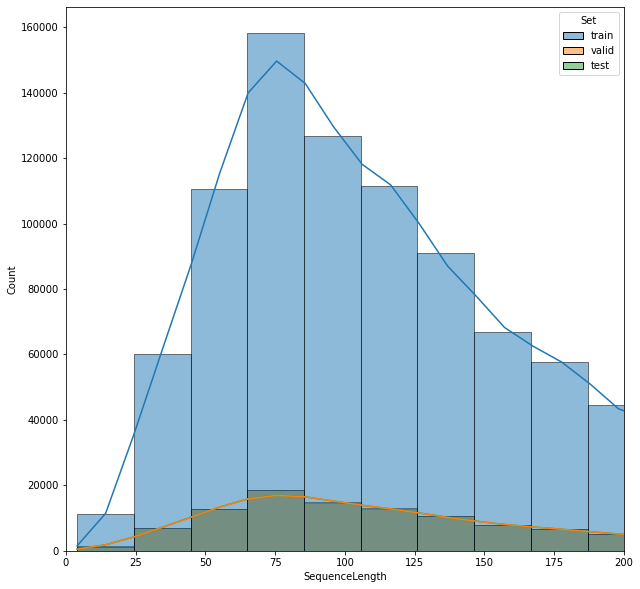

In [11]:
plt.figure(figsize=(10,10))
sns.histplot(data=seqlen_df, x="SequenceLength", hue="Set", kde=True, bins=100)
plt.xlim(0,200)

We can observe that the all three sets follow the same distribution of the length of sequences. It seems that the distribution follows the Poisson distribution with λ=75 amino acids.

Next, we analyze the target classes and see how they are distributed in each of the sets!


In [12]:
train_labels = train_df.family_accession.value_counts().to_dict()
valid_labels = valid_df.family_accession.value_counts().to_dict()
test_labels = test_df.family_accession.value_counts().to_dict()
print('The number of target classes in train set: %d' % len(train_labels))
print('The number of target classes in validation set: %d' % len(valid_labels))
print('The number of target classes in test set: %d' % len(test_labels))

print('\nRatio of target classes to number of samples in training set: %f' % (len(test_labels) / len(test_df)))

The number of target classes in train set: 17929
The number of target classes in validation set: 13071
The number of target classes in test set: 13071

Ratio of target classes to number of samples in training set: 0.103597


We have two problems here:
- Number of classes are not the same between train and validation/test sets.
- There are too many classes! We need a very complex architecture for this multi-class classification task. Also, the ratio of number of classes to the number of samples is around 0.1 which can be considered as a big number. This means we might not have enough samples to train a model sophisticated enough to extract embeddgings required for this classification task. In the subsequent section I will use the pre-trained models to transfer the contextual knowledge of the sequences. But for now we need to choose a subset of target classes (those that are more frequent).

Let's see if all the classes of the validation and test sets are covered by train set.

In [13]:
print(set(valid_labels.keys()) - set(test_labels.keys()))
print(set(test_labels.keys()) - set(train_labels.keys()))

set()
set()


So fortunately all the samples in the test and validation are included in traing set. Now we will find the common classes. 

In [14]:
# Find the common classes
classes_common = set(train_labels.keys()) & set(valid_labels.keys()) & set(test_labels.keys())

#Here we filter the train set based on the common target classes and re-define a new dataframe!
train_df = train_df.loc[train_df.family_accession.isin(classes_common)]
train_labels = train_df.family_accession.value_counts().to_dict()

We plot the histogram of the 50 most frequent classes of train, validation, and test set.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f32b5e10310>,
      dtype=object)

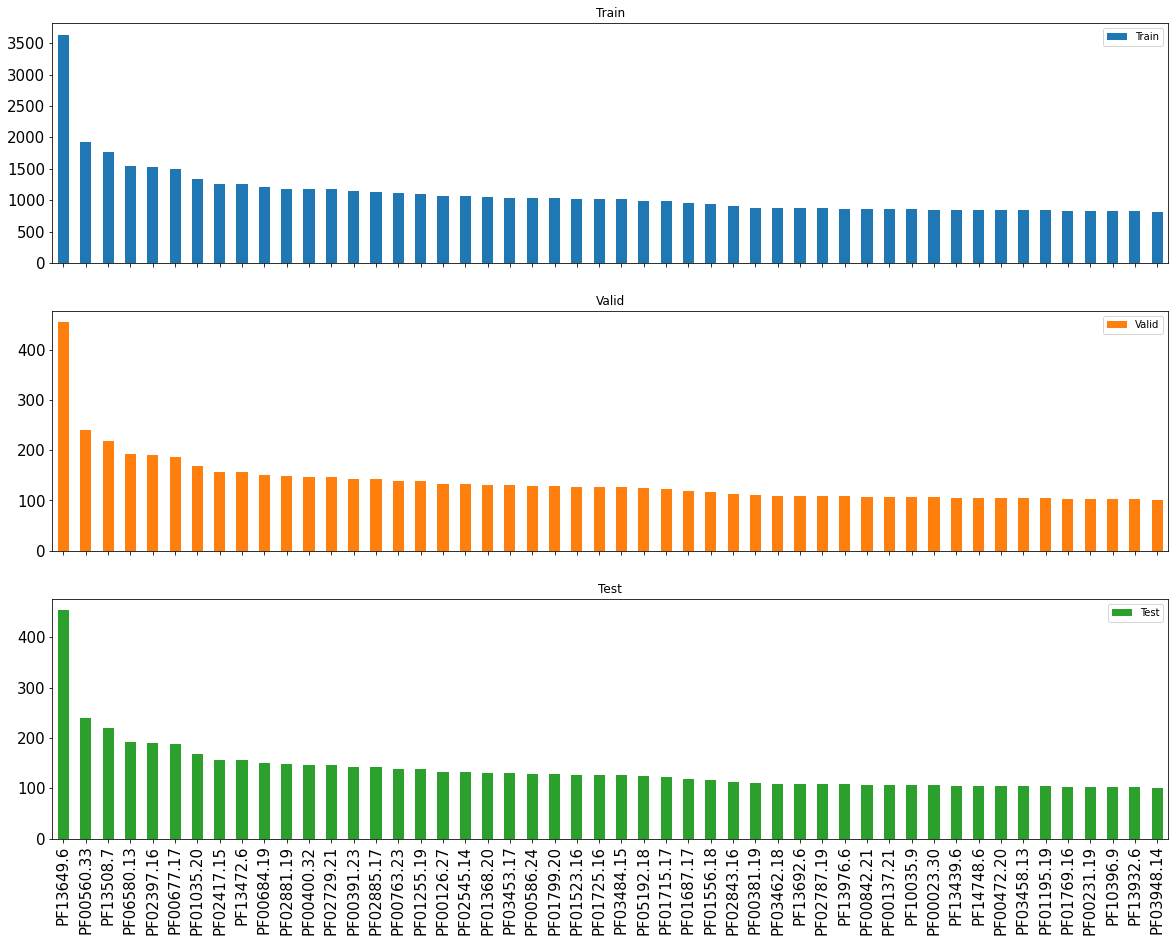

In [15]:
labels = {k:(train_labels[k], valid_labels[k], test_labels[k]) for k in classes_common}
labels_df = pd.DataFrame.from_dict(labels).T
labels_df.columns = ['Train', 'Valid', 'Test']
labels_df.sort_values(by=['Train'], ascending=False, inplace=True)
labels_df = labels_df.iloc[:50]
labels_df.plot.bar(figsize = (20,15), fontsize = 15, subplots=True)

We pick the 10 most frequent classes. This list will be used in the subsequent section when we want to visualize the embeddings in 2D space.

In [16]:
most_freq_classes = labels_df.iloc[:10].index.to_list()

The histogram of target classes follow the same distribution in all three sets. Also the order of the 50 most frequent classes is the same in all sets. But we still need to reduce number of target classes. We can filter out those classes with the occurence of less than 100.

In [17]:
chosen_train_labels = {k:v for k,v in train_labels.items() if v > 100}
chosen_valid_labels = {k:v for k,v in valid_labels.items() if v > 100}
chosen_test_labels = {k:v for k,v in test_labels.items() if v > 100}

#Again we calculate the common classes
classes_common = set(chosen_train_labels.keys()) & set(chosen_valid_labels.keys()) & set(chosen_test_labels.keys())

#And we re-defined all three sets
train_df = train_df.loc[train_df.family_accession.isin(classes_common)]
valid_df = valid_df.loc[valid_df.family_accession.isin(classes_common)]
test_df = test_df.loc[test_df.family_accession.isin(classes_common)]
chosen_train_labels = train_df.family_accession.value_counts().to_dict()
print('The number of target classes: %d' % len(chosen_train_labels))

The number of target classes: 52


Before we continue let's check one more time the proportion of each set and the distribution of the length of the sequences.

In [18]:
# The new proportion of the train, validation, and test sets
n_samples = len(train_df) + len(valid_df) + len(test_df) 
print('The proportion of train set: %f' % (len(train_df) / n_samples))
print('The proportion of valid set: %f' % (len(valid_df) / n_samples))
print('The proportion of test set: %f' % (len(test_df) / n_samples))

The proportion of train set: 0.800642
The proportion of valid set: 0.099679
The proportion of test set: 0.099679


(0.0, 750.0)

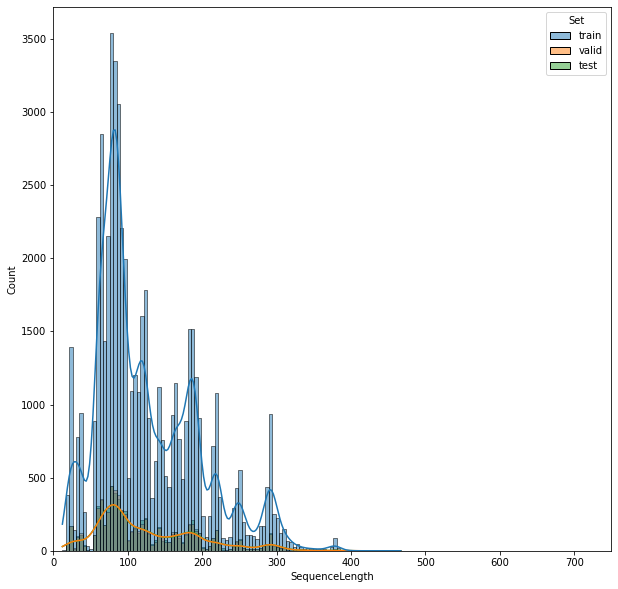

In [19]:
seqlen_train = list(zip(train_df.sequence.apply(len).to_list(), ['train']*len(train_df)))
seqlen_valid = list(zip(valid_df.sequence.apply(len).to_list(), ['valid']*len(valid_df)))
seqlen_test = list(zip(test_df.sequence.apply(len).to_list(), ['test']*len(test_df)))
seqlen_df = pd.DataFrame(data=seqlen_train+seqlen_valid+seqlen_test, columns=['SequenceLength','Set'])
plt.figure(figsize=(10,10))
sns.histplot(data=seqlen_df, x="SequenceLength", hue="Set", kde=True, bins=100)
plt.xlim(0,750)

These properties are preserved after the filtering we made on the number of target classes. 

# Language of life: Protein language models to extract embeddings from the sequences


## Protein language models

Protein language models are trained on millions of sequences using masked language modelling. These models are sophisticated enough to capture the interdependent hidden patterns from data. We can use these models to transfer the knowledge to other downstream tasks. This is particularly important if we have limited number of samples in our dataset. 

Paired with the advances in the hardware computational powers and the huge corpora of data, the self-supervised deep learning architectures become the centre of attention to train these encoder or pre-trained models. The resulted models serve in the extraction of informative representations from the input samples which has been demonstrated to be useful for different downstream tasks in the fields of natural language processing (NLP), machine vision, and recently masked language modelling methods to create pre-trained protein language models:

[bepler_learning_2021](https://www.sciencedirect.com/science/article/pii/S2405471221002039)

[vig_bertology_2021](https://arxiv.org/abs/2006.15222)

[elnaggar_prottrans_2021](https://ieeexplore.ieee.org/document/9477085)

[chowdhury_single-sequence_2021](https://www.biorxiv.org/content/10.1101/2021.08.02.454840v1.abstract)

[rives_biological_2021](https://www.pnas.org/doi/abs/10.1073/pnas.2016239118)

[zhou_mutation_2020](https://academic.oup.com/nargab/article/2/2/lqaa015/5781175?login=true)

## Two protein language models for our classification task

#### In this work I compare the performance of two pre-trained models:

#### 1) The first pre-trained model is called  **ProtTrans** which is inspired by [BERT](https://aclanthology.org/N19-1423/) and [transformers](https://proceedings.neurips.cc/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html) architecture

and trained using thousands GPUs and hundred of Google TPUs.

#### The article:
A. Elnaggar et al., "ProtTrans: Towards Cracking the Language of Lifes Code Through Self-Supervised Deep Learning and High Performance Computing," in IEEE Transactions on Pattern Analysis and Machine Intelligence, doi: 10.1109/TPAMI.2021.3095381.

#### Github repository:
https://github.com/agemagician/ProtTrans

#### Following their instructions on the Github repository we adapted their example code (*credit to RostLab*) on the feature extraction using model ProtT5-XL-U50 to our downstream classification problem here.


#### 2) The second approach that I found very interesting is ** Protein Sequence Embeddings (ProSE) ** which is a sequence-based **structure-aware** pre-trained model proposed by "Bepler and Berger" from MIT. Unlike **ProtTrans**, **ProSE** and its subsequent version **D-SCRIPT** are based on Bidirectional [LSTM](https://link.springer.com/chapter/10.1007/978-3-642-24797-2_4).

#### The article:
Tristan Bepler, Bonnie Berger,
Learning the protein language: Evolution, structure, and function,
Cell Systems,
Volume 12, Issue 6,
2021,
Pages 654-669.e3,
ISSN 2405-4712,
https://doi.org/10.1016/j.cels.2021.05.017.
(https://www.sciencedirect.com/science/article/pii/S2405471221002039)


#### Github repository:
https://github.com/tbepler/prose

# Preprocessing the samples

Before we start I extract the sequences from dataframes into dictionaries which is suitable as the input for ProtTrans model. Also for demonstration purposes, I choose the first 20000 samples from the train sample and 4000 first samples for the test and validation samples.

In [20]:
train_df = train_df.iloc[:10000]
valid_df = valid_df.iloc[:2000]
test_df = test_df.iloc[:2000]

seq_dict_train = dict(zip(train_df.sequence_name, train_df.sequence))
seq_dict_valid = dict(zip(valid_df.sequence_name, valid_df.sequence))
seq_dict_test = dict(zip(test_df.sequence_name, test_df.sequence))

In [21]:
print(train_df.sequence_name.to_list()[:10])
print(list(seq_dict_train.keys())[:10])

['Q6CLI7_KLULA/302-620', 'B6REL9_9BRAS/440-507', 'R5L2T5_9CLOT/161-265', 'I0IMD3_LEPFC/13-156', 'Q03GB6_PEDPA/377-456', 'Q53QA4_ORYSJ/398-468', 'R7YTK9_CONA1/178-268', 'D2PLR2_KRIFD/43-137', 'RLP19_ARATH/526-548', 'R5CFW5_9FIRM/63-147']
['Q6CLI7_KLULA/302-620', 'B6REL9_9BRAS/440-507', 'R5L2T5_9CLOT/161-265', 'I0IMD3_LEPFC/13-156', 'Q03GB6_PEDPA/377-456', 'Q53QA4_ORYSJ/398-468', 'R7YTK9_CONA1/178-268', 'D2PLR2_KRIFD/43-137', 'RLP19_ARATH/526-548', 'R5CFW5_9FIRM/63-147']


Here I transform the target classes into the one-hot encoding vectors that serves as labels for our multi-class classification task.

In [22]:
#Target: domain classes
classes_common = set(train_df.family_accession.to_list())
labels = [[x] for x in classes_common]
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot = encoder.fit(asarray(labels))

#Define the targets
train_labels_onehot = train_df.family_accession.apply(lambda x: encoder.transform([[x]])[0]).to_list()
valid_labels_onehot = valid_df.family_accession.apply(lambda x: encoder.transform([[x]])[0]).to_list()
test_labels_onehot = test_df.family_accession.apply(lambda x: encoder.transform([[x]])[0]).to_list()

train_labels_onehot = np.vstack(train_labels_onehot)
valid_labels_onehot = np.vstack(valid_labels_onehot)
test_labels_onehot = np.vstack(test_labels_onehot)
train_labels_onehot.shape

(10000, 52)

As we have observed from the beginning the train set is imbalance. This means the occurrences of the target classes is not the same. Therefore to update the model's parameters (weights) we need to assign more importance to the error of less frequent classes and less importance to the error of those that are more frequent. To do so, I use the class weights to compensate the imbalance effect.

In [23]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(sorted(train_df.family_accession.to_list())),
                                                  y = sorted(train_df.family_accession.to_list()))
d_class_weights = dict(enumerate(class_weights))
len(d_class_weights)

52

# First we see how ProtTrans performs on the domain sequences

## Prepare the experimental setup

Create directory for storing model weights (2.3GB) and example sequences. Here we use the encoder-part of ProtT5-XL-U50 in half-precision (fp16) as it performed best in our benchmarks (also outperforming ProtBERT-BFD).

In [24]:
!mkdir protT5 # root directory for storing checkpoints, results etc
!mkdir protT5/protT5_checkpoint # directory holding the ProtT5 checkpoint
!mkdir protT5/output # directory for storing your embeddings

In [25]:
# whether to retrieve embeddings for each residue in a protein 
# --> Lx1024 matrix per protein with L being the protein's length
# as a rule of thumb: 1k proteins require around 1GB RAM/disk
per_residue = False 
per_residue_path = "./protT5/output/per_residue_embeddings.h5" # where to store the embeddings

# whether to retrieve per-protein embeddings 
# --> only one 1024-d vector per protein, irrespective of its length
per_protein = True
per_protein_path = "./protT5/output/per_protein_embeddings.h5" # where to store the embeddings

Extraction of embeddings is a time consuming process and it's essential to have access to GPU or TPU resources to accelerate this process.

In [26]:
#Check whether GPU is available. { display-mode: "form" }
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))

Using cuda:0


We load the encoder-part of ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50)

In [27]:
def get_T5_model():
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc")
    model = model.to(device) # move model to GPU
    model = model.eval() # set model to evaluation model
    tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)

    return model, tokenizer

In [28]:
#@title Generate embeddings. { display-mode: "form" }
# Generate embeddings via batch-processing
# per_residue indicates that embeddings for each residue in a protein should be returned.
# per_protein indicates that embeddings for a whole protein should be returned (average-pooling)
# max_residues gives the upper limit of residues within one batch
# max_seq_len gives the upper sequences length for applying batch-processing
# max_batch gives the upper number of sequences per batch
def get_embeddings( model, tokenizer, seqs, per_residue, per_protein,
                   max_residues=4000, max_seq_len=1000, max_batch=100 ):
    results = {"residue_embs" : dict(), 
               "protein_embs" : dict()}

    # sort sequences according to length (reduces unnecessary padding --> speeds up embedding)
    seq_dict   = sorted( seqs.items(), key=lambda kv: len( seqs[kv[0]] ), reverse=True )
    start = time.time()
    batch = list()
    for seq_idx, (pdb_id, seq) in enumerate(seq_dict,1):
        seq = seq
        seq_len = len(seq)
        seq = ' '.join(list(seq))
        batch.append((pdb_id,seq,seq_len))

        # count residues in current batch and add the last sequence length to
        # avoid that batches with (n_res_batch > max_residues) get processed 
        n_res_batch = sum([ s_len for  _, _, s_len in batch ]) + seq_len 
        if len(batch) >= max_batch or n_res_batch>=max_residues or seq_idx==len(seq_dict) or seq_len>max_seq_len:
            pdb_ids, seqs, seq_lens = zip(*batch)
            batch = list()

            # add_special_tokens adds extra token at the end of each sequence
            token_encoding = tokenizer.batch_encode_plus(seqs, add_special_tokens=True, padding="longest")
            input_ids      = torch.tensor(token_encoding['input_ids']).to(device)
            attention_mask = torch.tensor(token_encoding['attention_mask']).to(device)
            
            try:
                with torch.no_grad():
                    # returns: ( batch-size x max_seq_len_in_minibatch x embedding_dim )
                    embedding_repr = model(input_ids, attention_mask=attention_mask)
            except RuntimeError:
                print("RuntimeError during embedding for {} (L={})".format(pdb_id, seq_len))
                continue

            for batch_idx, identifier in enumerate(pdb_ids): # for each protein in the current mini-batch
                s_len = seq_lens[batch_idx]
                # slice off padding --> batch-size x seq_len x embedding_dim  
                emb = embedding_repr.last_hidden_state[batch_idx,:s_len]
                if per_residue: # store per-residue embeddings (Lx1024)
                    results["residue_embs"][ identifier ] = emb.detach().cpu().numpy().squeeze()
                if per_protein: # apply average-pooling to derive per-protein embeddings (1024-d)
                    protein_emb = emb.mean(dim=0)
                    results["protein_embs"][identifier] = protein_emb.detach().cpu().numpy().squeeze()


    passed_time=time.time()-start
    avg_time = passed_time/len(results["residue_embs"]) if per_residue else passed_time/len(results["protein_embs"])
    print('\n############# EMBEDDING STATS #############')
    print('Total number of per-residue embeddings: {}'.format(len(results["residue_embs"])))
    print('Total number of per-protein embeddings: {}'.format(len(results["protein_embs"])))
    print("Time for generating embeddings: {:.1f}[m] ({:.3f}[s/protein])".format(
        passed_time/60, avg_time ))
    print('\n############# END #############')
    return results

Write embeddings to disk

In [29]:
def save_embeddings(emb_dict,out_path):
    with h5py.File(str(out_path), "w") as hf:
        for sequence_id, embedding in emb_dict.items():
            # noinspection PyUnboundLocalVariable
            hf.create_dataset(sequence_id, data=embedding)
    return None

## Extract the embeddings

Now we are going to extract embeddings for each of the sequences of tain, validation, and test sets. In this process ProtTrans extracts a vector of size 1024 for each sequence.

In [30]:
# Load the encoder part of ProtT5-XL-U50 in half-precision (recommended)
model, tokenizer = get_T5_model()

start = time.time()
Embedding_train = get_embeddings(model, tokenizer, seq_dict_train, per_residue, per_protein)
Embedding_valid = get_embeddings(model, tokenizer, seq_dict_valid, per_residue, per_protein)
Embedding_test = get_embeddings(model, tokenizer, seq_dict_test, per_residue, per_protein)
end = time.time()
print('Execution time: {} seconds'.format(end - start))

#Free some memory
gc.collect()
#Embedding_train["residue_embs"] = None
#Embedding_valid["residue_embs"] = None
#Embedding_test["residue_embs"] = None

#Re-order the embeddings
#Embedding_train["residue_embs"] = {x: Embedding_train["residue_embs"][x] for x in train_df.sequence_name.to_list()}
Embedding_train["protein_embs"] = {x: Embedding_train["protein_embs"][x] for x in train_df.sequence_name.to_list()}

#Embedding_valid["residue_embs"] = {x: Embedding_valid["residue_embs"][x] for x in valid_df.sequence_name.to_list()}
Embedding_valid["protein_embs"] = {x: Embedding_valid["protein_embs"][x] for x in valid_df.sequence_name.to_list()}

#Embedding_test["residue_embs"] = {x: Embedding_test["residue_embs"][x] for x in test_df.sequence_name.to_list()}
Embedding_test["protein_embs"] = {x: Embedding_test["protein_embs"][x] for x in test_df.sequence_name.to_list()}

# Save the embeddings
"""
if per_residue:
  save_embeddings(Embedding_train["residue_embs"], per_residue_path.replace('.h5', '_train.h5'))
  save_embeddings(Embedding_valid["residue_embs"], per_residue_path.replace('.h5', '_valid.h5'))
  save_embeddings(Embedding_test["residue_embs"], per_residue_path.replace('.h5', '_test.h5'))
"""
if per_protein:
  save_embeddings(Embedding_train["protein_embs"], per_protein_path.replace('.h5', '_train.h5'))
  save_embeddings(Embedding_valid["protein_embs"], per_protein_path.replace('.h5', '_valid.h5'))
  save_embeddings(Embedding_test["protein_embs"], per_protein_path.replace('.h5', '_test.h5'))

Downloading:   0%|          | 0.00/656 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.25G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]


############# EMBEDDING STATS #############
Total number of per-residue embeddings: 0
Total number of per-protein embeddings: 10000
Time for generating embeddings: 16.2[m] (0.097[s/protein])

############# END #############

############# EMBEDDING STATS #############
Total number of per-residue embeddings: 0
Total number of per-protein embeddings: 2000
Time for generating embeddings: 3.3[m] (0.100[s/protein])

############# END #############

############# EMBEDDING STATS #############
Total number of per-residue embeddings: 0
Total number of per-protein embeddings: 2000
Time for generating embeddings: 3.3[m] (0.100[s/protein])

############# END #############
Execution time: 1371.3720972537994 seconds


In [31]:
print(train_df.sequence_name.to_list()[:10])
print(list(seq_dict_train.keys())[:10])
print(list(Embedding_train["protein_embs"].keys())[:10])

['Q6CLI7_KLULA/302-620', 'B6REL9_9BRAS/440-507', 'R5L2T5_9CLOT/161-265', 'I0IMD3_LEPFC/13-156', 'Q03GB6_PEDPA/377-456', 'Q53QA4_ORYSJ/398-468', 'R7YTK9_CONA1/178-268', 'D2PLR2_KRIFD/43-137', 'RLP19_ARATH/526-548', 'R5CFW5_9FIRM/63-147']
['Q6CLI7_KLULA/302-620', 'B6REL9_9BRAS/440-507', 'R5L2T5_9CLOT/161-265', 'I0IMD3_LEPFC/13-156', 'Q03GB6_PEDPA/377-456', 'Q53QA4_ORYSJ/398-468', 'R7YTK9_CONA1/178-268', 'D2PLR2_KRIFD/43-137', 'RLP19_ARATH/526-548', 'R5CFW5_9FIRM/63-147']
['Q6CLI7_KLULA/302-620', 'B6REL9_9BRAS/440-507', 'R5L2T5_9CLOT/161-265', 'I0IMD3_LEPFC/13-156', 'Q03GB6_PEDPA/377-456', 'Q53QA4_ORYSJ/398-468', 'R7YTK9_CONA1/178-268', 'D2PLR2_KRIFD/43-137', 'RLP19_ARATH/526-548', 'R5CFW5_9FIRM/63-147']


In [32]:
"""
train_labels = [train_df.loc[train_df.sequence_name == k].family_accession.iloc[0] for k, v in Embedding_train['protein_embs'].items()]
valid_labels = [valid_df.loc[valid_df.sequence_name == k].family_accession.iloc[0] for k, v in Embedding_valid['protein_embs'].items()]
test_labels = [test_df.loc[test_df.sequence_name == k].family_accession.iloc[0] for k, v in Embedding_test['protein_embs'].items()]
test_labels
"""

"\ntrain_labels = [train_df.loc[train_df.sequence_name == k].family_accession.iloc[0] for k, v in Embedding_train['protein_embs'].items()]\nvalid_labels = [valid_df.loc[valid_df.sequence_name == k].family_accession.iloc[0] for k, v in Embedding_valid['protein_embs'].items()]\ntest_labels = [test_df.loc[test_df.sequence_name == k].family_accession.iloc[0] for k, v in Embedding_test['protein_embs'].items()]\ntest_labels\n"

Create train, validation, and test input matrices

In [33]:
X_train = np.vstack(list(Embedding_train['protein_embs'].values()))
X_valid = np.vstack(list(Embedding_valid['protein_embs'].values()))
X_test = np.vstack(list(Embedding_test['protein_embs'].values()))

Free some memory

In [34]:
%xdel Embedding_train
%xdel Embedding_valid
%xdel Embedding_test
%xdel model
%xdel tokenizer
gc.collect()

202

We can visualize the principle components of the embeddings of the train set using t-SNE.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(10000, 2)


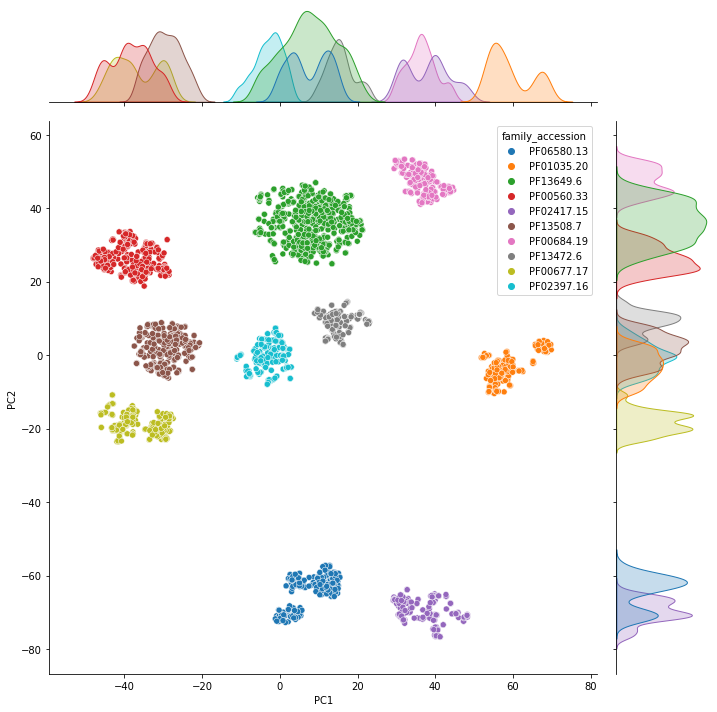

In [35]:
X_embedded = TSNE(n_components=2,random_state=42).fit_transform(X_train)
X_embedded_single = TSNE(n_components=1,random_state=42).fit_transform(X_train)

print(X_embedded.shape)

train_df['PC1'] = X_embedded[:,0]
train_df['PC2'] = X_embedded[:,1]
train_df['PC_single'] = X_embedded_single


train_df_top10 = train_df.loc[train_df.family_accession.isin(most_freq_classes)]
train_df_top10.reset_index(inplace=True)

#plt.rcParams.update({'font.size': 10})
#plt.figure(figsize=(20,20))
sns.jointplot(data=train_df_top10, x='PC1', y='PC2', hue = 'family_accession', height=10)

#### **Impressive**! ⭐
We can see that the distribution of the embeddings of 10 most frequent domains are separable when they are represented by t-SNE. 

Before the downstream task, I'm interested to study the structure of one of these domains. I chose domain family PF13649.6 (Methyltransferase domain) and highlighted this domain on the structure of biological assembly (in red) of Human HMT1 hnRNP methyltransferase-like protein 6 (S. cerevisiae) (PDB code: 5WCF).


<img src='https://drive.google.com/uc?id=17mBxGywlMOYqy0t50wTUiEYtSs5a0Vt1'>

I was interested to study the residues of the domain based on the one dimensional mapping of the residue-based embeddings. (I will do it later) 

In [36]:
train_df.loc[train_df.family_accession == 'PF13649.6']

,family_id,sequence_name,family_accession,aligned_sequence,sequence,PC1,PC2,PC_single
161,Methyltransf_25,D2PLR2_KRIFD/43-137,PF13649.6,ALDLGCGE.G...A..DA...IW..LA.GQ............G......,ALDLGCGEGADAIWLAGQGWTVTAVDISAVALERAARHAEQAGVAD...,20.588209,36.533310,-7.742924
868,Methyltransf_25,H3G8G0_PHYRM/30-123,PF13649.6,VLELAAGI.G...R..YT...SV..IA.KR.......A...........,VLELAAGIGRYTSVIAKRAKSVTAVEFIEDFIKVNADNNSHLGNIT...,-1.224717,34.700371,0.771223
1109,Methyltransf_25,R0JXY7_SETT2/102-197,PF13649.6,VLDAGAGS.G...Y..VA...MT..MA.RR.......G...........,VLDAGAGSGYVAMTMARRGLDVQAIDITPHHIADAKKNIEKYGLQD...,4.955265,36.654156,-0.606443
1829,Methyltransf_25,K7ITS6_NASVI/73-169,PF13649.6,ALDCGAGI.G...R..IT...GN..LL.TK.......F...........,ALDCGAGIGRITGNLLTKFFDTVDLVEQNPKFLEQAKQYLKKSMGK...,-1.537680,34.728565,1.091691
2243,Methyltransf_25,D1BJP6_SANKS/62-160,PF13649.6,IVDLGAGT.G...T..GT...LA..LA.AR.......F...PG......,IVDLGAGTGTGTLALAARFPGAQVHSLDATATMLERLTDSADAAGL...,17.673571,36.525379,-7.179896
...,...,...,...,...,...,...,...,...
1896,Methyltransf_25,D2R2V9_PIRSD/201-296,PF13649.6,VLDIGCGC.G...V..VG...LV..IC.KR.......L...........,VLDIGCGCGVVGLVICKRLPTATVLAIDSHSRAIECTQASAERNEL...,-1.448018,26.018898,2.343242
2114,Methyltransf_25,A3I2S0_9BACT/54-152,PF13649.6,VLDVGCGA.G...N..YT...LM..ML.SK.......L...........,VLDVGCGAGNYTLMMLSKLPNLHCTLVDLSQPMLDKAVERVSKVSK...,9.246207,33.937660,-0.926639
2907,Methyltransf_25,C6VSX8_DYAFD/45-136,PF13649.6,ILDAACGT.G...G..LL...WF..LV.EN............G......,ILDAACGTGGLLWFLVENGYSNVRGFDYSQHAIDFSKERGLNVVFG...,7.021731,30.592342,-1.328866
3896,Methyltransf_25,L7VLV6_CLOSH/105-198,PF13649.6,VLDYGCGD.G...F..IS...RG..IA.SH.......V...........,VLDYGCGDGFISRGIASHVGKVIAMDMSVSMLDELDRKAKLQGITN...,7.250645,43.388275,-3.615121


## Downstream task: multi-class classification to predict the class (family_accession) of the given protein domain.

## Train the downstream model

We define a deep neural network with multiple hidden layers. I choose the 

- I use activation function *ELU* instead of *ReLU* or *LeakyReLU* because unlike ReLU it doesn't have the problem of dead neurons during training. For more information please visit [here](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html).

- For the output layer I use *softmax* as the activation function

- For the loss function I use the *categorical cross-entropy* and the objective is to minimize this function with respect to the model's weights.

- I use the *Adam* optimiser for gradient descent. Btw here is a nice visualisation of the gradient descent: [here](https://github.com/Jaewan-Yun/optimizer-visualization)

- I use *dropout* layers to make the training process more challenging on the training set and avoid the overfitting.

In [37]:
def get_model(input_shape):
    """
    Model architecture
    """

    X_in = Input(shape=input_shape)
    
    H = Dense(500, use_bias=True, activation='elu', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3), kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(X_in)
    #H = Dropout(0.8)(H)
    #H = Dense(200, use_bias=True, activation='elu', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3), kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(H)
    H = Dense(100, use_bias=True, activation='elu', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3), kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(H)
    #H = Dropout(0.4)(H)
    Y = Dense(len(chosen_train_labels), activation='softmax')(H)

    _model = Model(inputs=[X_in], outputs=Y)
    _model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))
    _model.summary()
    
    return _model

Now let's train the model on 50 epoches and batch size 50

In [38]:
model = get_model(1024)
history = model.fit(X_train, train_labels_onehot, validation_data=(X_valid, valid_labels_onehot), batch_size=50, epochs=50, verbose=0, class_weight=d_class_weights, callbacks=[TqdmCallback(verbose=2)])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 500)               512500    
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
 dense_2 (Dense)             (None, 52)                5252      
                                                                 
Total params: 567,852
Trainable params: 567,852
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


0epoch [00:00, ?epoch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

Plot the train and validation losses

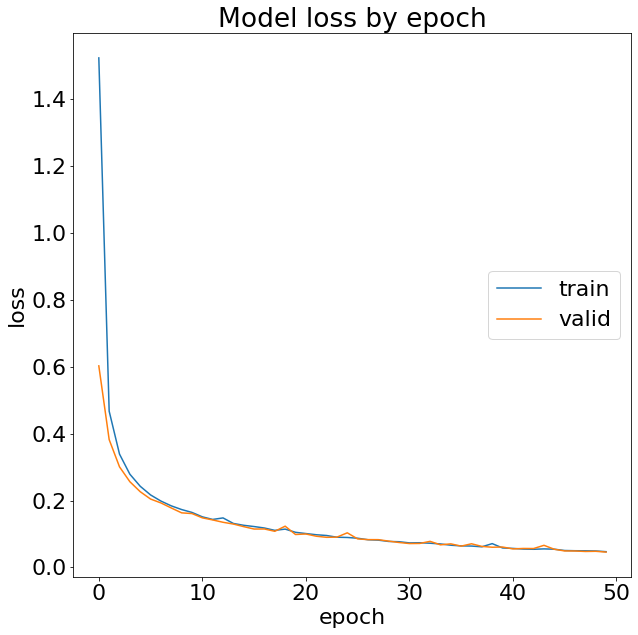

In [39]:
def plot_train_val_loss(history):
  # --------------------------------------
  # Loss functions evolution
  # --------------------------------------
  plt.figure(figsize=(10,10))
  plt.rcParams.update({'font.size': 22})
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss by epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='right')
  plt.savefig('tf_trainvalcurve_scr_classificaiton.svg')
plot_train_val_loss(history)

Beautiful curve! But we haven't actually checked if there is a sequence identity between the domains in the train and validation/test sets!

## Prediction on the test set

Here we evaluate the performance of the model on the test set and report the results as a confusion matrix for the 10 most frequent cases. Also I could report the Precision-Recall (PR) curves for each class. PR-curve instead of ROC because the data is imbalanced. 

Make predictions

In [40]:
test_preds = model.predict(X_test)

Evaluation on test set

In [41]:
def evaluation(test_preds, y_test):
  y_test = np.argmax(y_test, axis=1)
  test_preds = np.argmax(test_preds, axis=1)

  test_df['y_test'] = y_test
  test_df['test_preds'] = test_preds

  test_df_top10 = test_df.loc[test_df.family_accession.isin(most_freq_classes)]
  test_df_top10.reset_index(inplace=True)

  y_test = test_df_top10.y_test.to_numpy()
  test_preds = test_df_top10.test_preds.to_numpy()

  cf_matrix = confusion_matrix(y_test, test_preds)

  np.save('tf_confusionmatrix_10label_classificaiton', cf_matrix)

  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]

  cf_matrix_percentage = cf_matrix/cf_matrix.sum(axis=1)[:,None]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix_percentage.flatten()]

  labels = [f"{v1}\n{v2}\n" for v1, v2 in
            zip(group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(10,10) #10 most frequent classes

  """
  font = {'family' : 'normal',
          #'weight' : 'bold',
          'size'   : 10}
  plt.rc('font', **font)
  """
  fig, ax = plt.subplots(figsize=(15,15))
  sns.heatmap(cf_matrix_percentage, annot=labels, fmt='', cmap='Blues', ax=ax, vmin=0, vmax=1, annot_kws={'fontsize': 10})

  ax.set_xlabel('Predicted family class')
  ax.set_ylabel('True family classes');
  ax.xaxis.set_ticklabels(most_freq_classes, rotation=45)
  ax.yaxis.set_ticklabels(most_freq_classes, rotation=45)

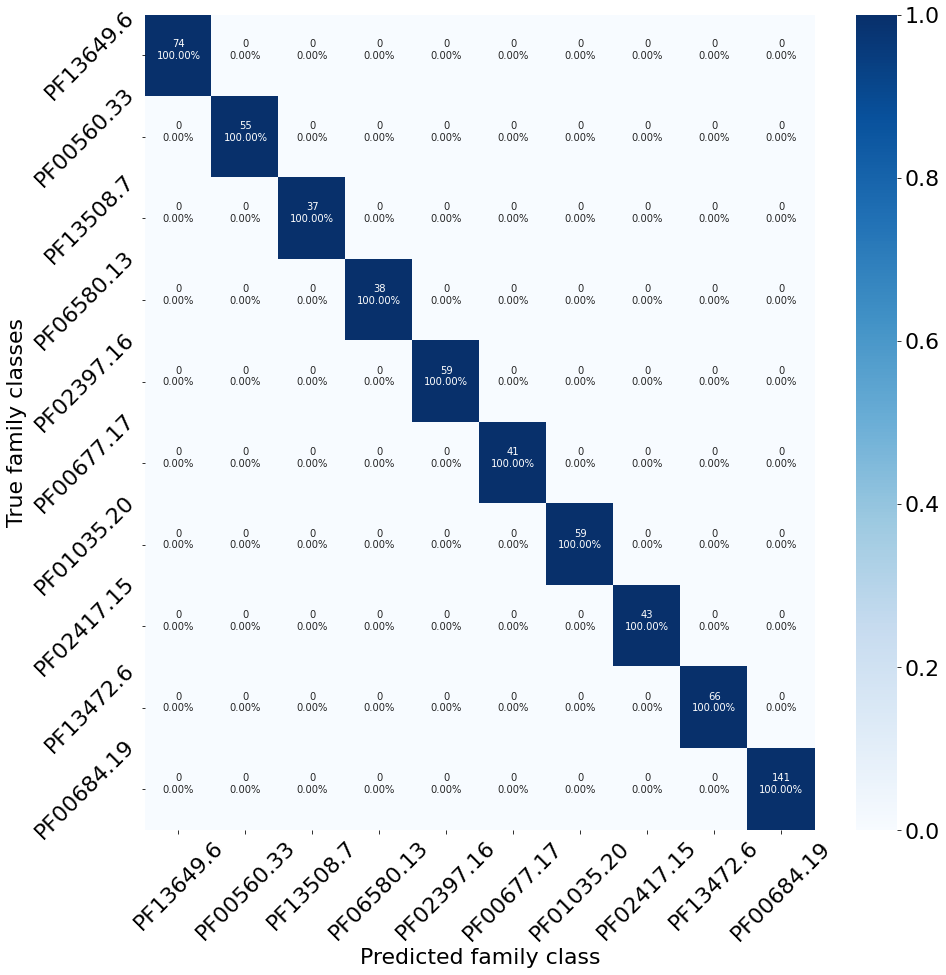

In [42]:
evaluation(test_preds, test_labels_onehot) 

Free some memory

In [43]:
%xdel X_train
%xdel X_valid
%xdel X_test
gc.collect()

14099

# Now let's see how ProSE performs for our downstream task

## Prepare the experimental setup

Clone the repository

In [44]:
!git clone https://github.com/tbepler/prose.git

Cloning into 'prose'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 1), reused 23 (delta 1), pack-reused 0
Unpacking objects: 100% (26/26), done.


Download and decompress the pre-trained model

In [45]:
!wget -nc -P prose/ http://bergerlab-downloads.csail.mit.edu/prose/saved_models.zip

--2022-07-20 20:25:06--  http://bergerlab-downloads.csail.mit.edu/prose/saved_models.zip
Resolving bergerlab-downloads.csail.mit.edu (bergerlab-downloads.csail.mit.edu)... 128.30.48.147
Connecting to bergerlab-downloads.csail.mit.edu (bergerlab-downloads.csail.mit.edu)|128.30.48.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 581846360 (555M) [application/zip]
Saving to: ‘prose/saved_models.zip’

saved_models.zip    100%[===================>] 554.89M  82.3MB/s    in 6.9s    

2022-07-20 20:25:13 (80.0 MB/s) - ‘prose/saved_models.zip’ saved [581846360/581846360]



In [46]:
!unzip -q -n prose/saved_models.zip -d prose/

Install all the requirements of ProSE

In [47]:
#!pip install -r prose/requirements.txt

Write the sequences of the train, validation, and test sets into corresponding fasta files. This is because to use script `embed_sequences.py` easily. Otherwise we need to integrate its code into our notebook here.

In [48]:
with open('prose/data/train_domains.fa','w') as f_handler:
  for k,v in seq_dict_train.items():
    f_handler.write('>'+k.replace('/','@') +'\n')
    f_handler.write(v+'\n')

with open('prose/data/valid_domains.fa','w') as f_handler:
  for k,v in seq_dict_valid.items():
    f_handler.write('>'+k.replace('/','@')+'\n')
    f_handler.write(v+'\n')

with open('prose/data/test_domains.fa','w') as f_handler:
  for k,v in seq_dict_test.items():
    f_handler.write('>'+k.replace('/','@')+'\n')
    f_handler.write(v+'\n')

## Extract the embeddings

In [49]:
start = time.time()
!python3 prose/embed_sequences.py --pool avg -o prose/data/train_domains.h5 prose/data/train_domains.fa
!python3 prose/embed_sequences.py --pool avg -o prose/data/valid_domains.h5 prose/data/valid_domains.fa
!python3 prose/embed_sequences.py --pool avg -o prose/data/test_domains.h5 prose/data/test_domains.fa
end = time.time()
print('Execution time: {} seconds'.format(end - start))

# loading the pre-trained ProSE MT model
# writing: prose/data/train_domains.h5
# embedding with pool=avg
# loading the pre-trained ProSE MT model
# writing: prose/data/valid_domains.h5
# embedding with pool=avg
# loading the pre-trained ProSE MT model
# writing: prose/data/test_domains.h5
# embedding with pool=avg
Execution time: 823.6140713691711 seconds


It's a still time consuming process! but ProSE is much faster than ProtTrans! **817** seconds for ProSE vs **1330** seconds for ProtTrans!

In [50]:
hf_train = h5py.File('prose/data/train_domains.h5', 'r')
hf_valid = h5py.File('prose/data/valid_domains.h5', 'r')
hf_test = h5py.File('prose/data/test_domains.h5', 'r')

embedding_prose_train = {x: np.array(hf_train[x.replace('/','@')]) for x in train_df.sequence_name.to_list()}
embedding_prose_valid = {x: np.array(hf_valid[x.replace('/','@')]) for x in valid_df.sequence_name.to_list()}
embedding_prose_test = {x: np.array(hf_test[x.replace('/','@')]) for x in test_df.sequence_name.to_list()}

In [51]:
print(train_df.sequence_name.to_list()[:10])
print(list(seq_dict_train.keys())[:10])
print(list(embedding_prose_train.keys())[:10])

['Q6CLI7_KLULA/302-620', 'B6REL9_9BRAS/440-507', 'R5L2T5_9CLOT/161-265', 'I0IMD3_LEPFC/13-156', 'Q03GB6_PEDPA/377-456', 'Q53QA4_ORYSJ/398-468', 'R7YTK9_CONA1/178-268', 'D2PLR2_KRIFD/43-137', 'RLP19_ARATH/526-548', 'R5CFW5_9FIRM/63-147']
['Q6CLI7_KLULA/302-620', 'B6REL9_9BRAS/440-507', 'R5L2T5_9CLOT/161-265', 'I0IMD3_LEPFC/13-156', 'Q03GB6_PEDPA/377-456', 'Q53QA4_ORYSJ/398-468', 'R7YTK9_CONA1/178-268', 'D2PLR2_KRIFD/43-137', 'RLP19_ARATH/526-548', 'R5CFW5_9FIRM/63-147']
['Q6CLI7_KLULA/302-620', 'B6REL9_9BRAS/440-507', 'R5L2T5_9CLOT/161-265', 'I0IMD3_LEPFC/13-156', 'Q03GB6_PEDPA/377-456', 'Q53QA4_ORYSJ/398-468', 'R7YTK9_CONA1/178-268', 'D2PLR2_KRIFD/43-137', 'RLP19_ARATH/526-548', 'R5CFW5_9FIRM/63-147']


Create train, validation, and test input matrices

In [52]:
X_train = np.vstack(list(embedding_prose_train.values()))
X_valid = np.vstack(list(embedding_prose_valid.values()))
X_test = np.vstack(list(embedding_prose_test.values()))

In [53]:
X_train.shape

(10000, 6165)

We can visualize the principle components of the embeddings of the train set using t-SNE.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(10000, 2)


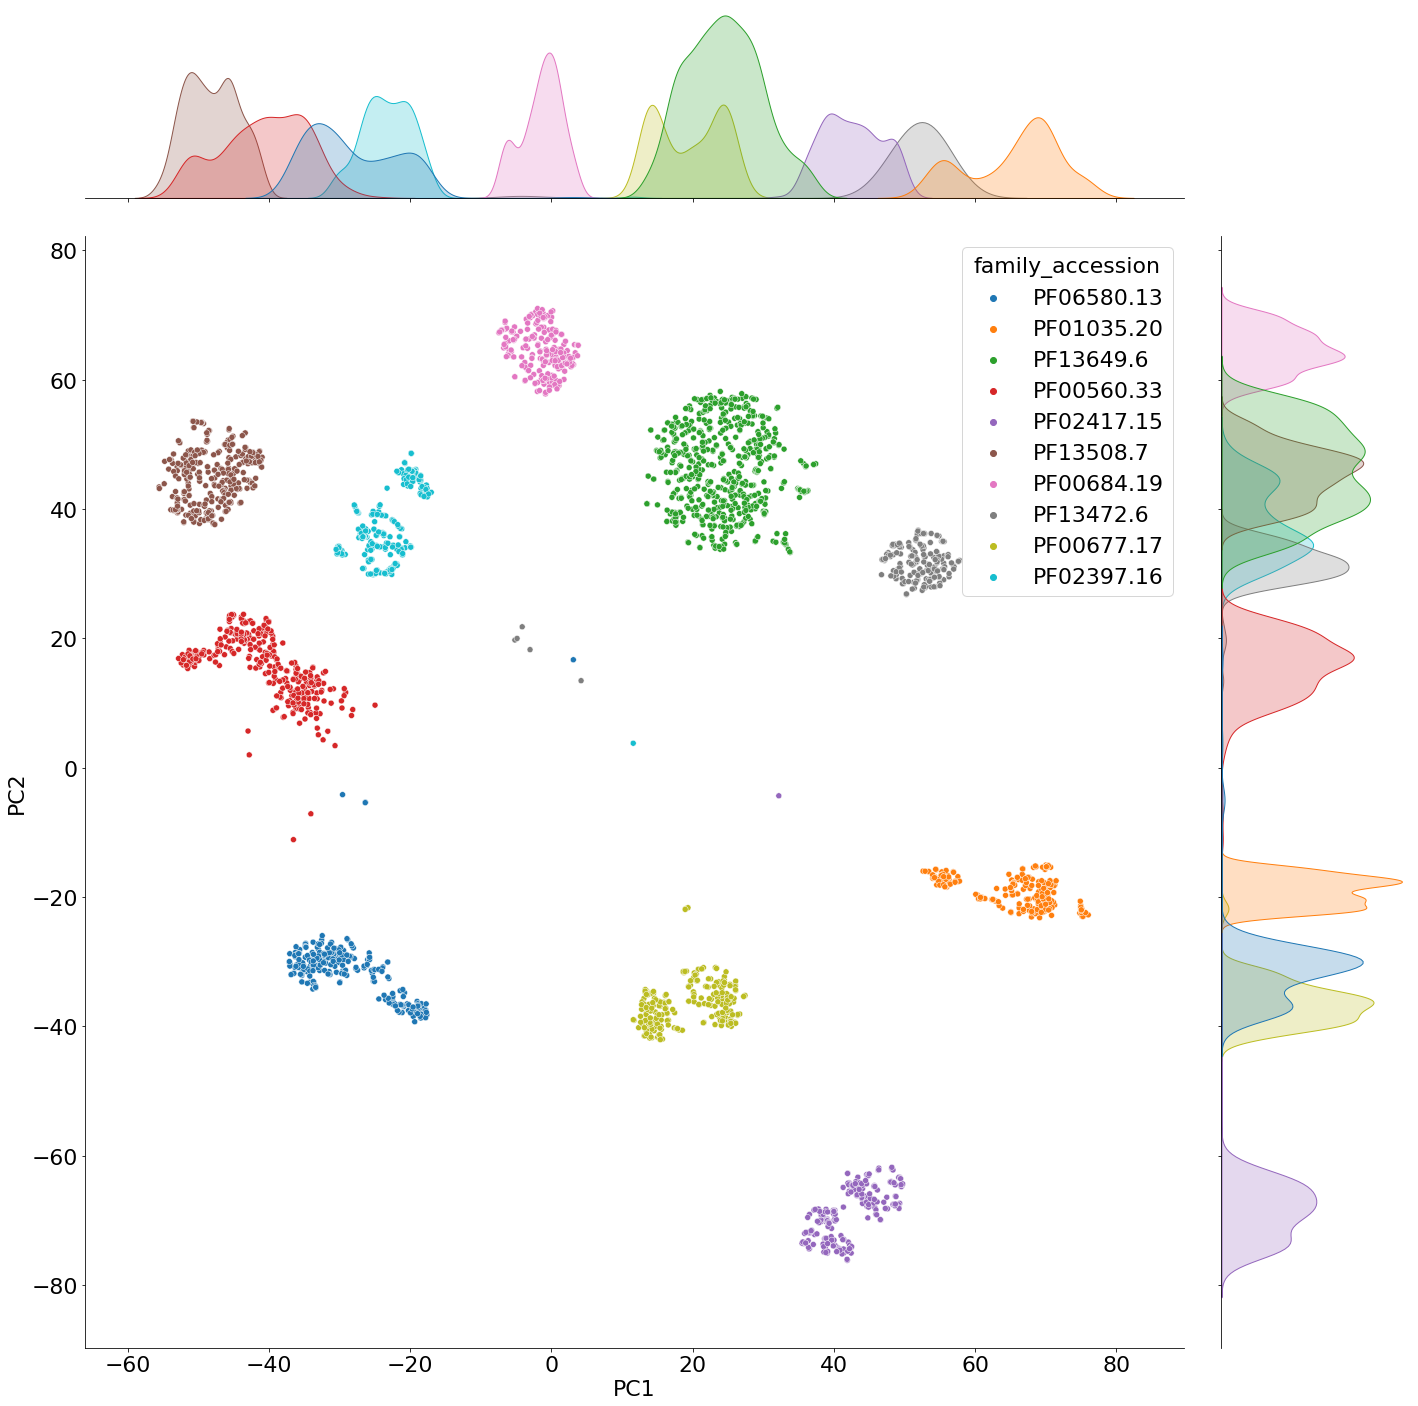

In [54]:
X_embedded = TSNE(n_components=2,random_state=42).fit_transform(X_train)
X_embedded_single = TSNE(n_components=1,random_state=42).fit_transform(X_train)

print(X_embedded.shape)

train_df['PC1'] = X_embedded[:,0]
train_df['PC2'] = X_embedded[:,1]
train_df['PC_single'] = X_embedded_single


train_df_top10 = train_df.loc[train_df.family_accession.isin(most_freq_classes)]
train_df_top10.reset_index(inplace=True)

#plt.rcParams.update({'font.size': 10})
#plt.figure(figsize=(20,20))
sns.jointplot(data=train_df_top10, x='PC1', y='PC2', hue = 'family_accession', height=20)

#### **Impressive**! ⭐
We can see that the distribution of the embeddings of 10 most frequent domains are separable when they are represented by t-SNE. 

## Train the downstream model

Now let's train the model on 50 epoches and batch size 50

In [55]:
model = get_model(6165)
history = model.fit(X_train, train_labels_onehot, validation_data=(X_valid, valid_labels_onehot), batch_size=50, epochs=50, verbose=0, class_weight=d_class_weights, callbacks=[TqdmCallback(verbose=2)])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6165)]            0         
                                                                 
 dense_3 (Dense)             (None, 500)               3083000   
                                                                 
 dense_4 (Dense)             (None, 100)               50100     
                                                                 
 dense_5 (Dense)             (None, 52)                5252      
                                                                 
Total params: 3,138,352
Trainable params: 3,138,352
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


0epoch [00:00, ?epoch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

Plot the train and validation losses

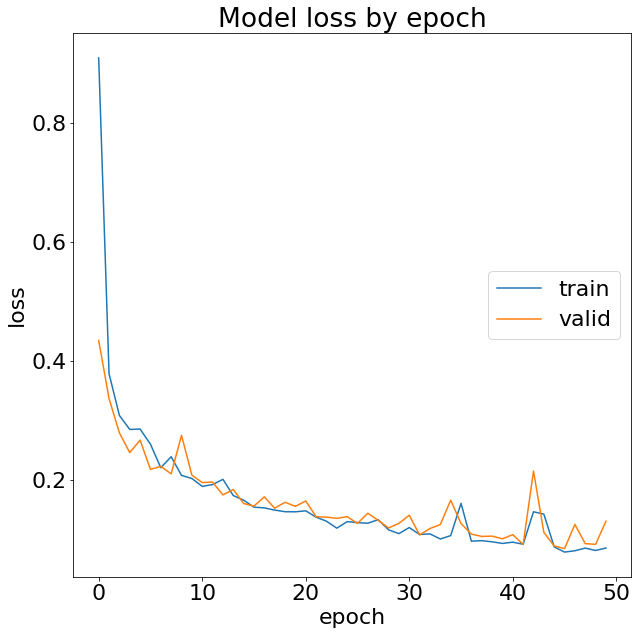

In [56]:
plot_train_val_loss(history)

We didn't check the sequence similarity between train and test set! It would have been nice to filter the results based on various levels of sequence identity of the sequences!

## Prediction on the test set

Here we evaluate the performance of the model on the test set and report the results as a confusion matrix for the 10 most frequent cases. Also I could report the Precision-Recall (PR) curves for each class. PR-curve instead of ROC because the data is imbalanced. 

Make predictions

In [57]:
test_preds = model.predict(X_test)

# Conclusion

Both protein language models performed well in the extraction of embeddings. Using t-SNE algorithm we could clearly see the separability of the embeddings in the 2D space for the 10 most frequent family domain classes. This shows these models even can be used for zero-shot classification. Not surprisingly the downstream tasks were successful for both sets of the embeddings even without using any fine-tunining techniques to adapt the parameters of the pre-trained models to the defined task, or without performing grid search to find the best hyper-parameters in which the validation curve converges (no need for early stopping). 

However, we didn't check the sequence similarity between train and test sets! It would have been nice to filter the results based on various levels of sequence identity of the sequences!

It is worth mentionning that ProSE is much faster than ProtTrans on both GPU and CPU! 

I look forward to evaluate the performance of these pre-trained models for other problems in the bioinformatics such as prediction of the intrinsically disordered regions, interaction sites, or effects of missense mutations.

***Designed by Yasser MOHSENI BEHBAHANI, 2022***